In [173]:
import requests
import csv
from bs4 import BeautifulSoup as bs
import pandas as pd
from pymystem3 import Mystem
import plotly.express as px
import matplotlib.pyplot as plt

In [174]:
header = {'Accept': '*/*', 
              'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1 Safari/605.1.15'}


In [175]:
#вставить ссылку с поискового запроса на hh
base_url = 'https://hh.ru/search/vacancy?clusters=true&area=1&enable_snippets=true&salary=&st=searchVacancy&text=python+analyst'

In [176]:
pagination_url = base_url + '&page'

In [177]:
pagination_url

'https://hh.ru/search/vacancy?clusters=true&area=1&enable_snippets=true&salary=&st=searchVacancy&text=python+analyst&page'

In [178]:
urls = []
set_of_links = set()
session = requests.Session()
big_dict = dict()
big_dict_requirments = dict()

request_ = session.get(base_url, headers=header)


In [179]:
if request_.status_code == 200:
    
    soup = bs(request_.content, 'lxml')

else:
    print('error from hh.ru response')

In [180]:
number_of_pages

20

In [181]:
try:
    pagination = soup.find_all('a', attrs={'data-qa': 'pager-page'})
    number_of_pages = int(pagination[-1].text)
    for i in range(number_of_pages + 1):
        url = f'{pagination_url}={i}'
        if url not in urls:
            urls.append(url)
except:
    print(request.status_code)

In [182]:
# получаем множество ссылок на вакансии set_of_links 
# и создаем словарь big_dict с ключем ссылка на вакансию и значением списком компания и должность
for url in urls:
    request = session.get(url, headers=header)
    soup = bs(request.content, 'lxml')
    divs = soup.find_all('div', attrs={'data-qa': 'vacancy-serp__vacancy'})
    for div in divs:
        title = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'}).text
        href = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'})['href']
        try:
            company = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-employer'}).text
        except:
            company = div.find('div', 'vacancy-serp-item__meta-info').text
        big_dict[href] = [company, title]
        set_of_links.add(href)

In [183]:
#Количество вакансий 
len(set_of_links)

964

In [184]:
# !!! ATTENTION для 20 страниц поисковой выдачи выполнение может занимать до 5 минут!! 

#составляем словарь big_dict_requirments ключевых навыков для каждой вакансии,
#если в вакансии не указан ключевые навыки, то заполняем пустой строкой

for vacancy_link in set_of_links:
    key_skills_list = []
    request = session.get(vacancy_link, headers=header)
    soup = bs(request.content, 'lxml')

    description = soup.find('div', attrs={'class': 'vacancy-description'})
    
    for row in description:
        key_skills = description.find_all('span', attrs={'data-qa': 'bloko-tag__text'})
        
    for key_skill in key_skills:
        key_skills_list.append(key_skill.text)
        
    if key_skills_list != []:
        big_dict_requirments[vacancy_link] = key_skills_list
    else:
        big_dict_requirments[vacancy_link] = ''

In [185]:
#создаем df с колонками: 1) ссылка на вакансию(уникальный ключ/индекс таблицы), 2) компанией и 3) названием должности/позиции
general_df = pd.DataFrame.from_dict(data=big_dict, columns=['company', 'title'], orient='index').reset_index()
general_df = general_df.rename(columns={'index':'link'})

#создаем df с колонками: 1) ссылка на вакансию(уникальный ключ), 2) список ключевых навыков
description_df = pd.DataFrame.from_dict(data=big_dict_requirments, columns=['key_skills'], orient='index').reset_index()
description_df = description_df.rename(columns={'index':'link'})

#объединяем два df по ключу ссылка
total_df = general_df.merge(description_df, on='link')

In [186]:
total_df.head()

,link,company,title,key_skills
0,https://hh.ru/vacancy/34533419?query=python%20...,ManyChat,Intern/Junior Data Analyst,"[Математическая статистика, MS SQL, R, Python,..."
1,https://hh.ru/vacancy/31648507?query=python%20...,ManyChat,Senior Product / Data Analyst,"[Анализ бизнес показателей, Анализ временных р..."
2,https://hh.ru/vacancy/33986951?query=python%20...,LATOKEN,Trading Analyst,"[Investment Analysis, Investment Banking, Взаи..."
3,https://hh.ru/vacancy/36024461?query=python%20...,ООО НТС,Аналитик данных,"[SQL, Python, Data Mining, Data Analysis, Анал..."
4,https://hh.ru/vacancy/36059974?query=python%20...,"Агентство 21 век, КЦ",Quantitative Analyst,"[Английский — C1 — Продвинутый, Python, Матема..."


In [187]:
total_df.loc[0,'key_skills']

['Математическая статистика', 'MS SQL', 'R', 'Python', 'Математический анализ']

In [188]:
#считаем количество вакансий, где не заполнены ключевые навыки
total_df[total_df['key_skills'] == ''].count()

link          270
company       270
title         270
key_skills    270
dtype: int64

In [189]:
#считаем долю вакансий, где не заполнены ключевые навыки
total_df[total_df['key_skills'] == ''].count() / total_df.count()

link          0.280083
company       0.280083
title         0.280083
key_skills    0.280083
dtype: float64

In [190]:
#топ - 10 компаний, которые не заполнили ключевые навыки в вакансии, отсортированные по количеству вакансий
total_df[total_df['key_skills']== ''].groupby('company').agg({'title':'count'})\
    .sort_values(by='title', ascending=False).head(10)

,title
company,
Сбербанк для экспертов,46
Банк ВТБ (ПАО),9
АО ДОМ.РФ,7
Тинькофф,6
Авито,6
Group-IB,6
ivi,5
Леруа Мерлен. Центральный офис,4
QIWI,4


In [191]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 963
Data columns (total 4 columns):
link          964 non-null object
company       964 non-null object
title         964 non-null object
key_skills    964 non-null object
dtypes: object(4)
memory usage: 77.7+ KB


In [192]:
#функция возвращает словарь, в котором считаем частоту ключвых навыков, по колонке 'key_skills' в df
def words_counter(df):
    merged = dict()
    for row in df['key_skills']:
        if row is None:
            pass
        else:
            for word in row:
                if word in merged:
                    merged[word] += 1
                else:
                    merged[word] = 1
    return {k: v for k, v in sorted(merged.items(), key=lambda item: item[1], reverse=True)}
    

In [193]:
words_counter = words_counter(total_df)

In [194]:
# создаем df с ключемвыми навыками и их частотой
skills_df = pd.DataFrame.from_dict(data=words_counter, columns=['skill'], orient='index').reset_index()

In [195]:
skills_df = skills_df.rename(columns={'index':'skill_', 'skill': 'count'})

In [196]:
#выводим топ-15 ключевых навыков по частоте
skills_df.head(15)

,skill_,count
0,Python,478
1,SQL,397
2,MS SQL,101
3,Linux,75
4,Анализ данных,71
5,Английский язык,71
6,Java,69
7,Data Mining,68
8,Git,66
9,PostgreSQL,61


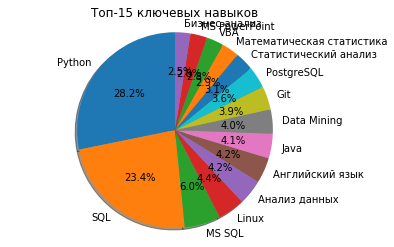

In [197]:
fig1, ax1 = plt.subplots()
ax1.pie(skills_df.head(15)['count'], labels=skills_df.head(15)['skill_'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Топ-15 ключевых навыков")
plt.show()